Iñigo Martin Melero

## Participante 30

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_30_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0    5.058     10
1           50      5.0    5.058     10
2          100      5.0    5.058     10
3          150      5.0    5.058     10
4          200      5.0    5.058     10
...        ...      ...      ...    ...
49027  2451350      5.0    5.000     12
49028  2451400      5.0    5.000     12
49029  2451450      5.0    5.000     12
49030  2451500      5.0    5.000     12
49031  2451550      5.0    5.000     12

[49032 rows x 4 columns]


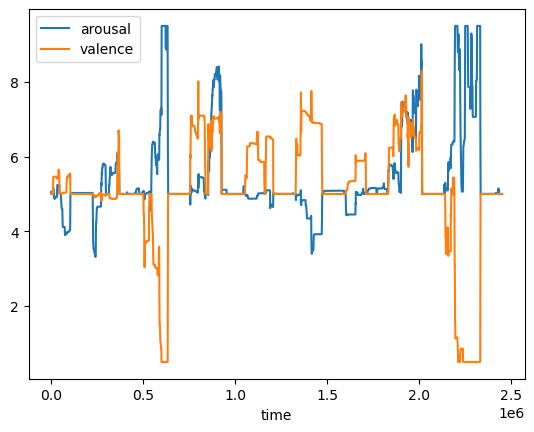

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_30_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.839  35.895  11.028  37.338  26.932     6.877    13.491   
1              1  0.846  36.021  10.969  37.309  26.928     6.877    13.327   
2              2  0.853  36.147  10.910  37.280  26.925     6.877    13.162   
3              3  0.859  36.273  10.851  37.251  26.921     6.877    12.998   
4              4  0.849  36.341  10.885  37.241  26.914     6.715    12.875   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  1.569  45.662   7.333  39.576  26.950    16.983    19.940   
2451580  2451580  1.579  45.778   7.294  39.595  26.957    17.106    20.063   
2451581  2451581  1.589  45.894   7.254  39.615  26.964    17.229    20.186   
2451582  2451582  1.599  46.011   7.215  39.634  26.971    17.352    20.309   
2451583  2451583  1.608  46.127   7.176  39.653  26.978    17.476    20.433   

         emg_trap  video  
0          23.553     10

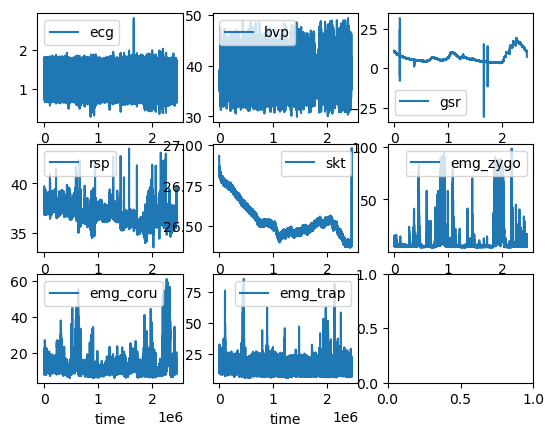

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

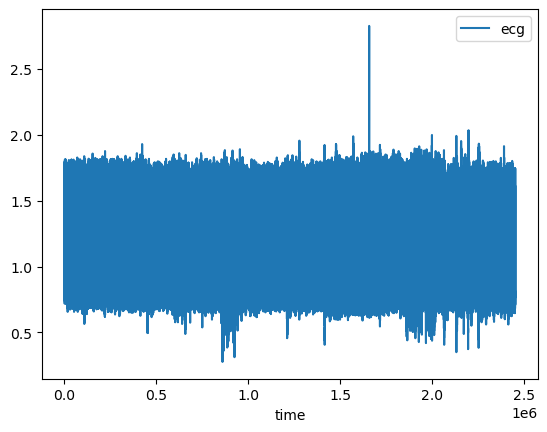

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

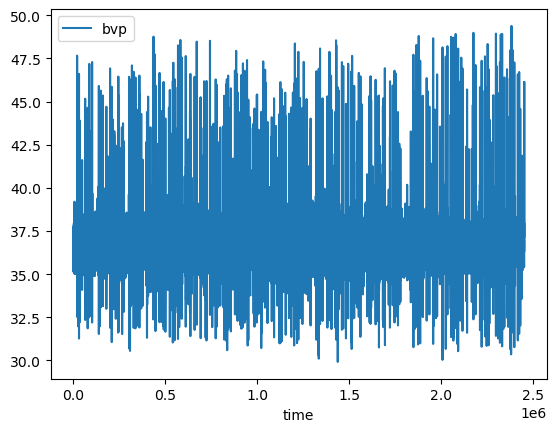

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

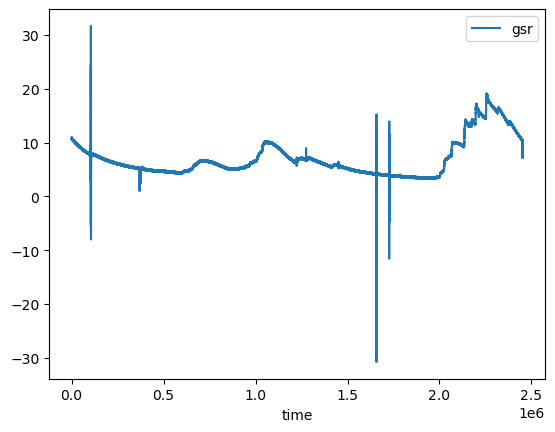

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

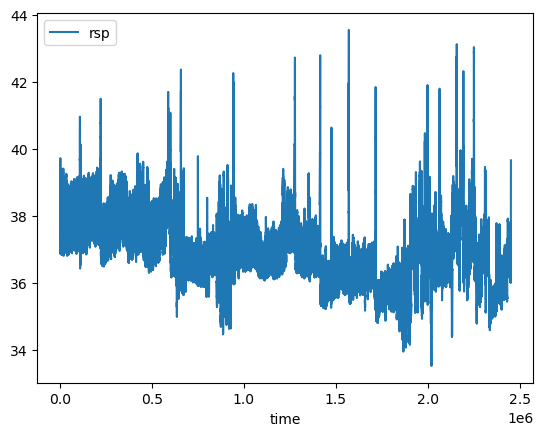

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

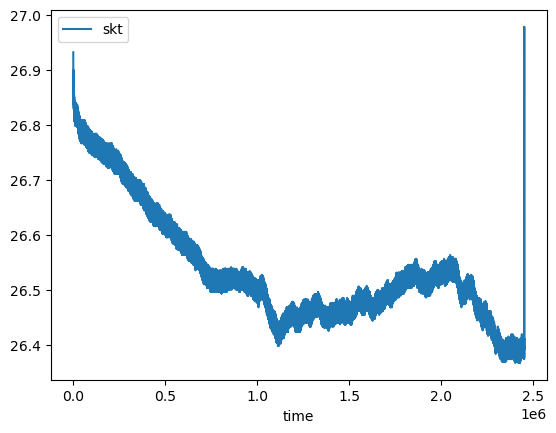

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

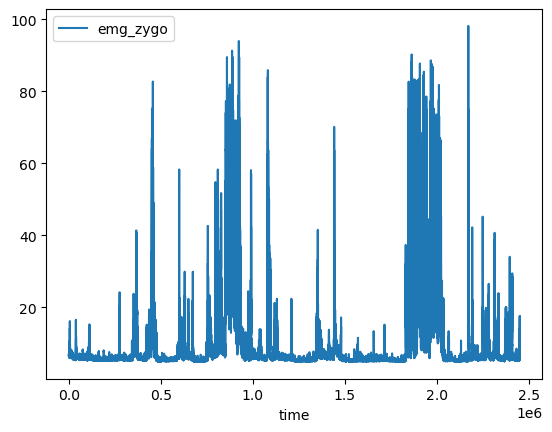

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

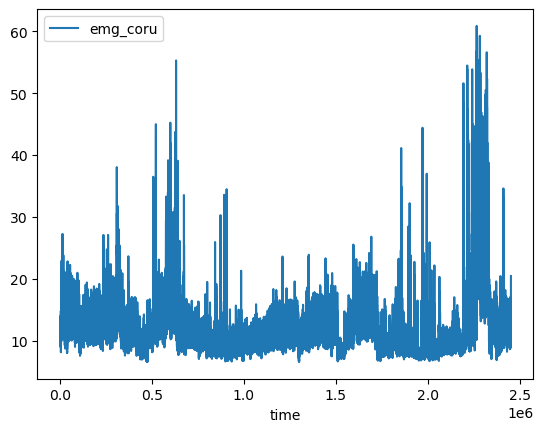

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

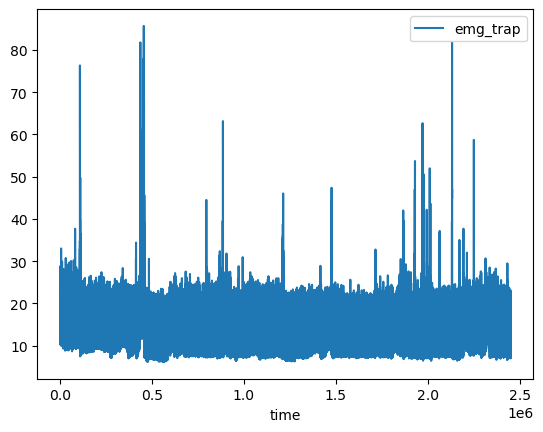

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

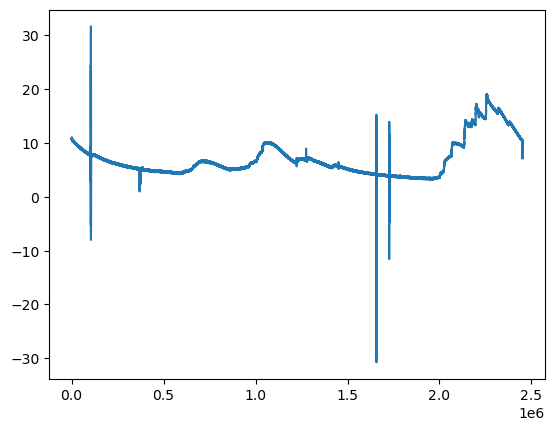

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

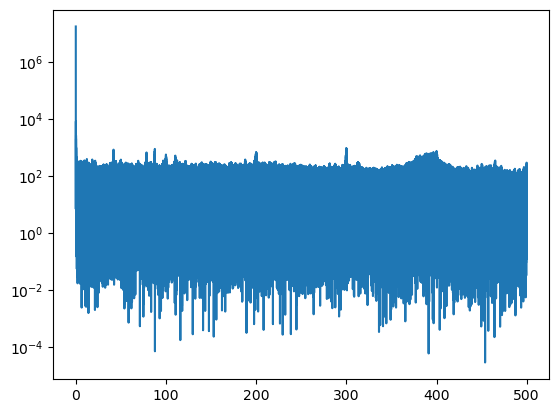

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

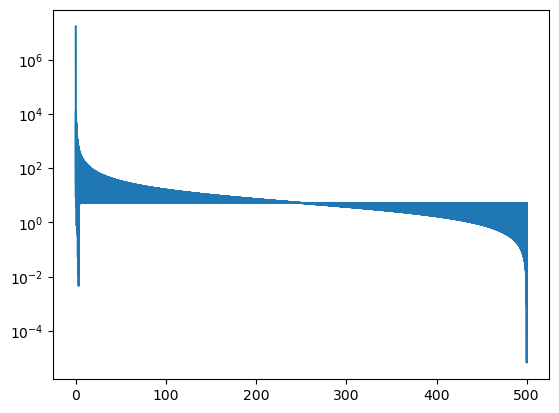

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

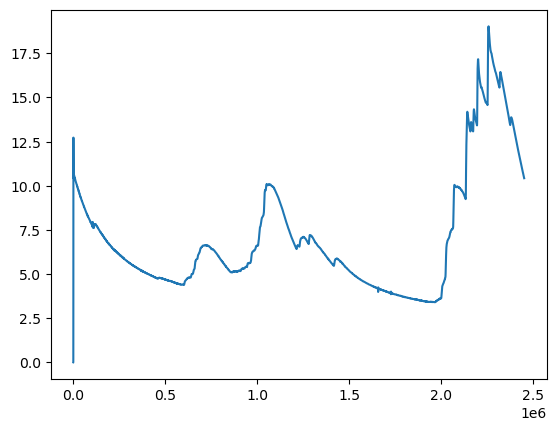

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  10.425
2451580  10.425
2451581  10.425
2451582  10.424
2451583  10.424

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

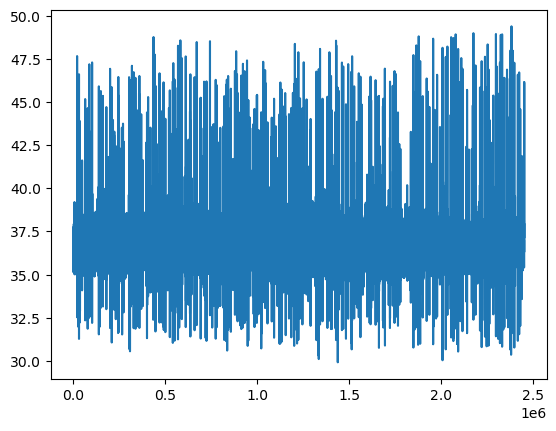

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

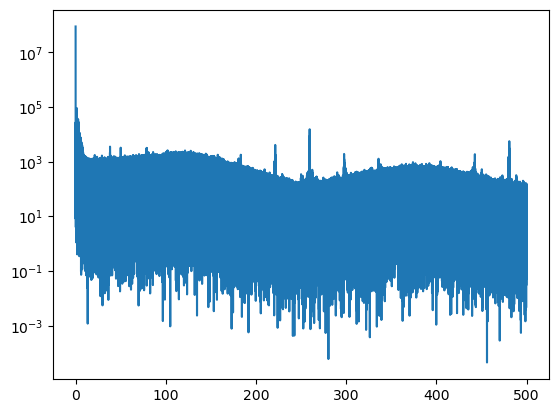

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

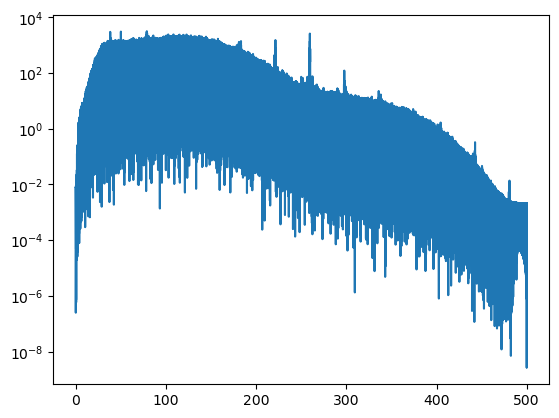

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

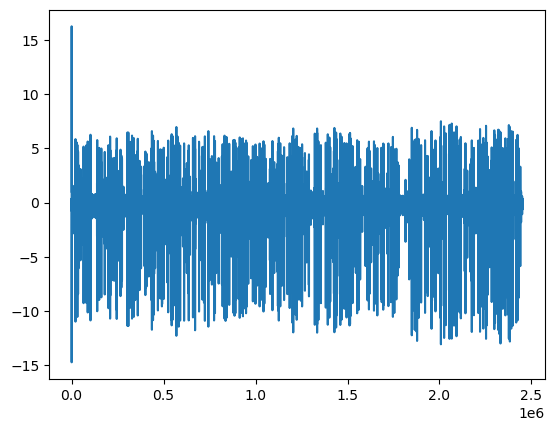

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.997
1        42.568
2        50.114
3        53.256
4        46.178
...         ...
2451579  36.996
2451580  36.996
2451581  36.995
2451582  36.996
2451583  36.996

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

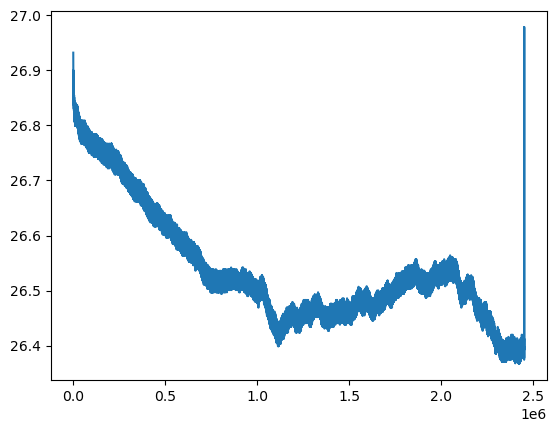

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

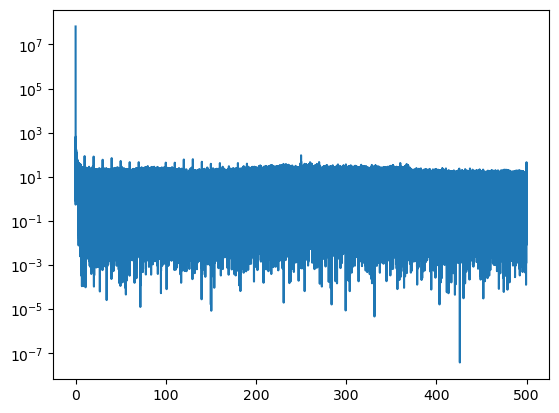

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

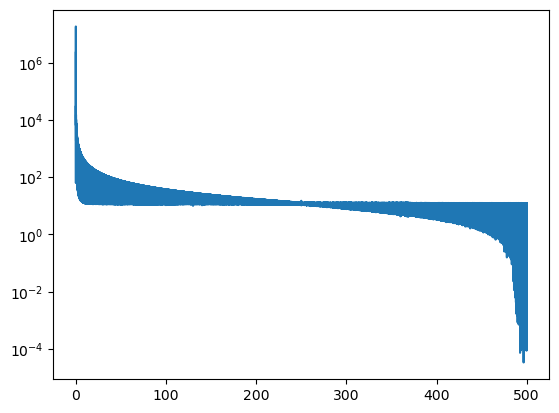

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

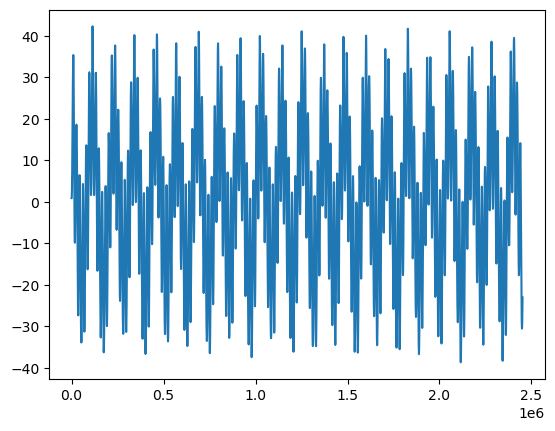

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.863
1        40.863
2        40.863
3        40.863
4        40.863
...         ...
2451579  16.915
2451580  16.919
2451581  16.924
2451582  16.928
2451583  16.933

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.839  37.338     6.877    13.491    23.553     10
1              1  0.846  37.309     6.877    13.327    23.266     10
2              2  0.853  37.280     6.877    13.162    22.979     10
3              3  0.859  37.251     6.877    12.998    22.692     10
4              4  0.849  37.241     6.715    12.875    22.485     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  1.569  39.576    16.983    19.940    18.831     12
2451580  2451580  1.579  39.595    17.106    20.063    18.954     12
2451581  2451581  1.589  39.615    17.229    20.186    19.077     12
2451582  2451582  1.599  39.634    17.352    20.309    19.200     12
2451583  2451583  1.608  39.653    17.476    20.433    19.324     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.839  37.338     6.877    13.491    23.553     10  37.997   
1              1  0.846  37.309     6.877    13.327    23.266     10  42.568   
2              2  0.853  37.280     6.877    13.162    22.979     10  50.114   
3              3  0.859  37.251     6.877    12.998    22.692     10  53.256   
4              4  0.849  37.241     6.715    12.875    22.485     10  46.178   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  1.569  39.576    16.983    19.940    18.831     12  36.996   
2451580  2451580  1.579  39.595    17.106    20.063    18.954     12  36.996   
2451581  2451581  1.589  39.615    17.229    20.186    19.077     12  36.995   
2451582  2451582  1.599  39.634    17.352    20.309    19.200     12  36.996   
2451583  2451583  1.608  39.653    17.476    20.433    19.324     12  36.996   

            gsr     skt  
0         0.000  40.863  
1         0.000  40.863  
2         0.000  40.863  
3         0.000  40.863  
4         0.000  40.863  
...         ...     ...  
2451579  10.425  16.915  
2451580  10.425  16.919  
2451581  10.425  16.924  
2451582  10.424  16.928  
2451583  10.424  16.933  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.223442  0.635405  0.189668  0.792947  0.620949  0.005286   
221502    221502  0.221090  0.636814  0.189668  0.792869  0.620949  0.006133   
221503    221503  0.217170  0.635745  0.189668  0.792791  0.619858  0.006144   
221504    221504  0.215602  0.635211  0.189668  0.792713  0.618767  0.006584   
221505    221505  0.212074  0.635551  0.189668  0.792648  0.619858  0.007023   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.236378  0.640896  0.803674  0.355697  0.427605  0.021124   
2331580  2331580  0.240298  0.640167  0.803674  0.355788  0.430769  0.021552   
2331581  2331581  0.237554  0.639244  0.803610  0.355866  0.429787  0.021124   
2331582  2331582  0.238730  0.637883  0.803610  0.355957  0.433933  0.022421   
2331583  2331583  0.231282  0.634676  0.803610  0.356035  0.431860  0.021563   

         emg_coru  emg_trap  video  
221501   0.082536  0.161487      6  
221502   0.083273  0.162910      6  
221503   0.084029  0.162927      6  
221504   0.083292  0.163629      6  
221505   0.084029  0.163647      6  
...           ...       ...    ...  
2331579  0.246797  0.142737      7  
2331580  0.245322  0.144159      7  
2331581  0.240805  0.144176      7  
2331582  0.241506  0.148460      7  
2331583  0.236270  0.151357      7  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0    5.058
1            5.0    5.059
2            5.0    5.060
3            5.0    5.060
4            5.0    5.061
...          ...      ...
2451579      5.0    5.054
2451580      5.0    5.055
2451581      5.0    5.055
2451582      5.0    5.056
2451583      5.0    5.057

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.223442  0.635405  0.189668  0.620949  0.792947  0.005286   
221502    221502  0.221090  0.636814  0.189668  0.620949  0.792869  0.006133   
221503    221503  0.217170  0.635745  0.189668  0.619858  0.792791  0.006144   
221504    221504  0.215602  0.635211  0.189668  0.618767  0.792713  0.006584   
221505    221505  0.212074  0.635551  0.189668  0.619858  0.792648  0.007023   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.236378  0.640896  0.803674  0.427605  0.355697  0.021124   
2331580  2331580  0.240298  0.640167  0.803674  0.430769  0.355788  0.021552   
2331581  2331581  0.237554  0.639244  0.803610  0.429787  0.355866  0.021124   
2331582  2331582  0.238730  0.637883  0.803610  0.433933  0.355957  0.022421   
2331583  2331583  0.231282  0.634676  0.803610  0.431860  0.356035  0.021563   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
221540   0.172089  0.636377  0.189668  0.604037  0.789945  0.006605  0.131759   
221560   0.163073  0.635113  0.189732  0.597709  0.788425  0.007034  0.108309   
221580   0.169345  0.630449  0.189732  0.591380  0.786878  0.006584  0.068138   
221600   0.424147  0.634433  0.189732  0.580797  0.785332  0.006584  0.065096   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.166993  0.634968  0.803930  0.425532  0.349148  0.037872  0.317239   
2331520  0.169345  0.638855  0.803866  0.425532  0.350798  0.029487  0.212009   
2331540  0.165425  0.628505  0.803802  0.426514  0.352461  0.024190  0.479214   
2331560  0.196394  0.639244  0.803738  0.431860  0.354124  0.020662  0.307413   
2331580  0.240298  0.640167  0.803674  0.430769  0.355788  0.021552  0.245322   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1      0.172089  0.636377  0.189668  0.604037  0.789945  0.006605  0.131759   
2      0.163073  0.635113  0.189732  0.597709  0.788425  0.007034  0.108309   
3      0.169345  0.630449  0.189732  0.591380  0.786878  0.006584  0.068138   
4      0.424147  0.634433  0.189732  0.580797  0.785332  0.006584  0.065096   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.166993  0.634968  0.803930  0.425532  0.349148  0.037872  0.317239   
63500  0.169345  0.638855  0.803866  0.425532  0.350798  0.029487  0.212009   
63501  0.165425  0.628505  0.803802  0.426514  0.352461  0.024190  0.479214   
63502  0.196394  0.639244  0.803738  0.431860  0.354124  0.020662  0.307413   
63503  0.240298  0.640167  0.803674  0.430769  0.355788  0.021552  0.245322   

       emg_trap  valence  arousal  
0      0.165806    5.000    5.025  
1      0.137013    5.000    5.025  
2      0.098757    5.000    5.025  
3      0.095140    5.000    5.025  
4      0.138418    5.000    5.025  
...         ...      ...      ...  
63499  0.131219    0.499    9.501  
63500  0.150637    0.499    9.501  
63501  0.172302    0.500    9.500  
63502  0.135521    0.501    9.499  
63503  0.144159    0.500    9.500  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1      0.172089  0.636377  0.189668  0.604037  0.789945  0.006605  0.131759   
2      0.163073  0.635113  0.189732  0.597709  0.788425  0.007034  0.108309   
3      0.169345  0.630449  0.189732  0.591380  0.786878  0.006584  0.068138   
4      0.424147  0.634433  0.189732  0.580797  0.785332  0.006584  0.065096   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.176009  0.641625  0.804314  0.419203  0.342468  0.023332  0.221079   
63496  0.177185  0.638564  0.804250  0.418112  0.344145  0.018915  0.408827   
63497  0.176009  0.629136  0.804122  0.421277  0.345808  0.017145  0.257453   
63498  0.170521  0.633364  0.804058  0.423350  0.347471  0.038269  0.230850   
63499  0.166993  0.634968  0.803930  0.425532  0.349148  0.037872  0.317239   

       emg_trap  valence  arousal  
0      0.165806    5.000    5.025  
1      0.137013    5.000    5.025  
2      0.098757    5.000    5.025  
3      0.095140    5.000    5.025  
4      0.138418    5.000    5.025  
...         ...      ...      ...  
63495  0.118930    0.499    9.501  
63496  0.127550    0.500    9.500  
63497  0.138383    0.501    9.499  
63498  0.178763    0.500    9.500  
63499  0.131219    0.499    9.501  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
 1   0.172089  0.636377  0.189668  0.604037  0.789945  0.006605  0.131759   
 2   0.163073  0.635113  0.189732  0.597709  0.788425  0.007034  0.108309   
 3   0.169345  0.630449  0.189732  0.591380  0.786878  0.006584  0.068138   
 4   0.424147  0.634433  0.189732  0.580797  0.785332  0.006584  0.065096   
 5   0.437868  0.641333  0.189732  0.575450  0.783786  0.007474  0.112070   
 6   0.185025  0.633656  0.189732  0.569122  0.782239  0.007452  0.087053   
 7   0.174441  0.639487  0.189732  0.561702  0.780693  0.006573  0.074941   
 8   0.165425  0.628456  0.189732  0.553301  0.779147  0.007463  0.073447   
 9   0.169345  0.638466  0.189732  0.549154  0.777587  0.007034  0.098427   
 10  0.177185  0.708732  0.189668  0.544899  0.776041  0.007903  0.087071   
 11  0.186201  0.625492  0.189668  0.537480  0.774469  0.007913  0.087809   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1     0.193650  0.638369  0.189604  0.435025  0.752560  0.006144  0.105249   
2     0.238730  0.635599  0.189092  0.313584  0.713395  0.007034  0.105249   
3     0.226186  0.640119  0.188516  0.299836  0.675321  0.007463  0.114337   
4     0.209330  0.638078  0.188452  0.290344  0.639469  0.010980  0.128699   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.364563  0.639438  0.813148  0.411893  0.164094  0.037411  0.358922   
2536  0.205410  0.637689  0.811420  0.365303  0.194306  0.051501  0.274837   
2537  0.191298  0.637883  0.809691  0.304092  0.229313  0.042708  0.266523   
2538  0.210506  0.634676  0.807771  0.296672  0.268010  0.028179  0.293734   
2539  0.541748  0.633704  0.805595  0.353737  0.309034  0.027289  0.431576   

             8         9        10  ...       193       194       195  \
0     0.165806  0.172089  0.636377  ...  0.191298  0.639195  0.189604   
1     0.120369  0.188554  0.634385  ...  0.262250  0.632441  0.189156   
2     0.099494  0.214426  0.636717  ...  0.464916  0.637980  0.188452   
3     0.264598  0.195218  0.640410  ...  0.210506  0.635794  0.188452   
4     0.096597  0.203058  0.635842  ...  0.273618  0.633413  0.187684   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.149250  0.197962  0.635794  ...  0.174441  0.638952  0.811484   
2536  0.201850  0.228538  0.642014  ...  0.172089  0.637592  0.809755   
2537  0.140595  0.168169  0.640556  ...  0.202666  0.637543  0.807899   
2538  0.137716  0.214426  0.639778  ...  0.257938  0.636960  0.805659   
2539  0.228502  0.157585  0.633558  ...  0.166993  0.634968  0.803930   

           196       197       198       199       200  valence  arousal  
0     0.442444  0.754132  0.007023  0.092362  0.114593  5.00000  5.02500  
1     0.315657  0.714941  0.008793  0.073429  0.100197  5.00000  5.02500  
2     0.302019  0.676802  0.008353  0.145346  0.114470  5.00000  5.02500  
3     0.291435  0.640847  0.011870  0.111259  0.106658  5.00000  5.02844  
4     0.335734  0.607984  0.007474  0.124182  0.118965  5.00000  5.02900  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.369558  0.193006  0.037840  0.271113  0.189561  0.50000  9.49996  
2536  0.306165  0.227831  0.033004  0.299817  0.168721  0.50000  9.49980  
2537  0.297654  0.266399  0.027718  0.124956  0.149900  0.50016  9.50012  
2538  0.349482  0.307370  0.034784  0.395240  0.124723  0.50000  9.50020  
2539  0.425532  0.349148  0.037872  0.317239  0.131219  0.49980  9.50020  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1     0.193650  0.638369  0.189604  0.435025  0.752560  0.006144  0.105249   
2     0.238730  0.635599  0.189092  0.313584  0.713395  0.007034  0.105249   
3     0.226186  0.640119  0.188516  0.299836  0.675321  0.007463  0.114337   
4     0.209330  0.638078  0.188452  0.290344  0.639469  0.010980  0.128699   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.364563  0.639438  0.813148  0.411893  0.164094  0.037411  0.358922   
2536  0.205410  0.637689  0.811420  0.365303  0.194306  0.051501  0.274837   
2537  0.191298  0.637883  0.809691  0.304092  0.229313  0.042708  0.266523   
2538  0.210506  0.634676  0.807771  0.296672  0.268010  0.028179  0.293734   
2539  0.541748  0.633704  0.805595  0.353737  0.309034  0.027289  0.431576   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub30.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1     0.193650  0.638369  0.189604  0.435025  0.752560  0.006144  0.105249   
2     0.238730  0.635599  0.189092  0.313584  0.713395  0.007034  0.105249   
3     0.226186  0.640119  0.188516  0.299836  0.675321  0.007463  0.114337   
4     0.209330  0.638078  0.188452  0.290344  0.639469  0.010980  0.128699   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.364563  0.639438  0.813148  0.411893  0.164094  0.037411  0.358922   
2536  0.205410  0.637689  0.811420  0.365303  0.194306  0.051501  0.274837   
2537  0.191298  0.637883  0.809691  0.304092  0.229313  0.042708  0.266523   
2538  0.210506  0.634676  0.807771  0.296672  0.268010  0.028179  0.293734   
2539  0.541748  0.633704  0.805595  0.353737  0.309034  0.027289  0.431576   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub30.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1     0.193650  0.638369  0.189604  0.435025  0.752560  0.006144  0.105249   
2     0.238730  0.635599  0.189092  0.313584  0.713395  0.007034  0.105249   
3     0.226186  0.640119  0.188516  0.299836  0.675321  0.007463  0.114337   
4     0.209330  0.638078  0.188452  0.290344  0.639469  0.010980  0.128699   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.364563  0.639438  0.813148  0.411893  0.164094  0.037411  0.358922   
2536  0.205410  0.637689  0.811420  0.365303  0.194306  0.051501  0.274837   
2537  0.191298  0.637883  0.809691  0.304092  0.229313  0.042708  0.266523   
2538  0.210506  0.634676  0.807771  0.296672  0.268010  0.028179  0.293734   
2539  0.541748  0.633704  0.805595  0.353737  0.309034  0.027289  0.431576   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub30.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1     0.193650  0.638369  0.189604  0.435025  0.752560  0.006144  0.105249   
2     0.238730  0.635599  0.189092  0.313584  0.713395  0.007034  0.105249   
3     0.226186  0.640119  0.188516  0.299836  0.675321  0.007463  0.114337   
4     0.209330  0.638078  0.188452  0.290344  0.639469  0.010980  0.128699   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.364563  0.639438  0.813148  0.411893  0.164094  0.037411  0.358922   
2536  0.205410  0.637689  0.811420  0.365303  0.194306  0.051501  0.274837   
2537  0.191298  0.637883  0.809691  0.304092  0.229313  0.042708  0.266523   
2538  0.210506  0.634676  0.807771  0.296672  0.268010  0.028179  0.293734   
2539  0.541748  0.633704  0.805595  0.353737  0.309034  0.027289  0.431576   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub30.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.185025  0.637009  0.189668  0.615603  0.791491  0.007463  0.074222   
1     0.193650  0.638369  0.189604  0.435025  0.752560  0.006144  0.105249   
2     0.238730  0.635599  0.189092  0.313584  0.713395  0.007034  0.105249   
3     0.226186  0.640119  0.188516  0.299836  0.675321  0.007463  0.114337   
4     0.209330  0.638078  0.188452  0.290344  0.639469  0.010980  0.128699   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.364563  0.639438  0.813148  0.411893  0.164094  0.037411  0.358922   
2536  0.205410  0.637689  0.811420  0.365303  0.194306  0.051501  0.274837   
2537  0.191298  0.637883  0.809691  0.304092  0.229313  0.042708  0.266523   
2538  0.210506  0.634676  0.807771  0.296672  0.268010  0.028179  0.293734   
2539  0.541748  0.633704  0.805595  0.353737  0.309034  0.027289  0.431576   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub30.csv', index=False)